# Handling time-constant singularities in integrate-and-fire neurons

This notebook details how NEST handles the numerical instability of the exact integration propagator matrix $P = e^{A h}$ which arise if $\tau_m\approx \tau_{\text{syn}}$. For an overview over exact integration of integrate-and-fire neuron subthreshold dynamics, please see `exact-integration.rst`.

We illustrate the approach for neurons with alpha-shaped currents, where the synaptic current is described by two differential equations. For exponential-shaped currents, a similar but simpler treatment applies.

The singularity-handling code is implemented in `libnestutil/iaf_propagator.[h,cpp]`.

## Preparations

We use SymPy to allow symbolic analysis of the propagator matrices and their limits.

In [1]:
import sympy as sp
from sympy.matrices import zeros
sp.init_printing(use_latex=True)

Introduce formal variables for time constants, capacitance and time step $h$.

In [2]:
tau_m, tau_s, C_m, h = sp.symbols('tau_m, tau_s, C_m, h', positive=True)

## The ODE matrix

The following matrix describes the ODE system for synaptic current and membrane potential (bottom row). It applies for singular and non-singular cases.

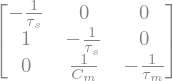

In [4]:
A = sp.Matrix([[-1/tau_s, 0, 0], [1, -1/tau_s ,0], [0, 1/C_m, -1/tau_m]])
A

## Propagator in the non-singular case ($\tau_m\neq \tau_s$) 

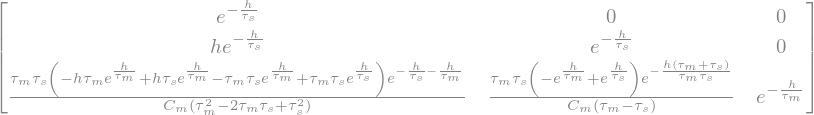

In [5]:
P = sp.simplify(sp.exp(A * h))
P

- The entries in the first two rows of $P$ are unproblematic, as is $P_{33}$.
- In the first two entries on the bottom row, $P_{31}$ and $P_{32}$, the denominators will vanish for $\tau_m\to\tau_s$.
- $P_{32}$ also appears in the propagator matrix for the case of exponential synaptic currents.

## Propagator in the singular case ($\tau_m = \tau_s$) 

In this case, we have

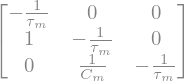

In [6]:
A_s = sp.Matrix([[-1/tau_m, 0, 0],[1, -1/tau_m, 0],[0, 1/C_m, -1/tau_m]])
A_s

and the propagator becomes

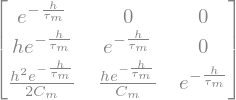

In [7]:
P_s = sp.simplify(sp.exp(A_s * h))
P_s

- This is well-formed and non-singular.
- The "unproblematic" matrix elements agree with the non-singular case.

## Numeric stability of propagator elements

We will now show that the matrix elements of the non-singular case converge to those in the general case, so that we have overall
$$
\lim_{\tau_s\to\tau_m} P = P_s\;.
$$

Using symbolic algebra we find for $\lim_{\tau_s\to\tau_m} P_{31} = P_{s,31}$:


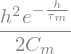

In [8]:
P_31 = P.row(2).col(0)[0]
P_31_l = sp.limit(P_31, tau_s, tau_m)
P_31_l

Test for mathematical equality [as recommended in SymPy](https://docs.sympy.org/dev/tutorials/intro-tutorial/gotchas.html#equals-signs)

In [9]:
sp.simplify(P_31_l - P_s.row(2).col(0)[0]) == 0

True

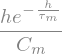

In [10]:
P_32 = P.row(2).col(1)[0]
P_32_l = sp.limit(P_32, tau_s, tau_m)
P_32_l

In [11]:
sp.simplify(P_32_l - P_s.row(2).col(1)[0]) == 0

True

## Approximation in the vicinity of the singularity

Since the propagator elements converge to the solution for the singular case, we can approximate the matrix elements near the singularity by expanding around $\tau_m$. We obtain

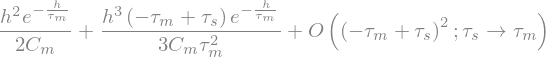

In [12]:
P_31.series(x=tau_s, x0=tau_m, n=2)

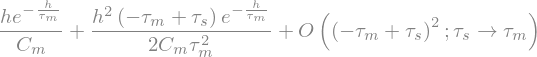

In [13]:
P_32.series(x=tau_s, x0=tau_m, n=2)

We thus have 

\begin{align}
P_{31} &= P_{s, 31} + \frac{2h}{3\tau_m^2}P_{s, 31}(\tau_s-\tau_m) + \mathcal{O}((\tau_s-\tau_m)^2)\\ 
P_{32} &= P_{s, 32} + \frac{h}{2\tau_m^2}P_{s, 32}(\tau_s-\tau_m) + \mathcal{O}((\tau_s-\tau_m)^2)
\end{align}

Focusing on $P_{32}$ and dropping the quadratic term, we obtain
$$
\left|\frac{P_{32}-P_{s, 32}}{P_{s, 32}}\right|\approx \left|\frac{h(\tau_s-\tau_m)}{2\tau_m^2}\right| \ll 1
$$
where the inequality follows because $|\tau_s-\tau_m|\ll \tau_m$ by definition in the near-singular case and $h<\tau_m$ for all practical purposes.

Any violation of this inequality indicates numerical instability in the computation of $P_{32}$.

The corresponding inequality for $P_{31}$ is
$$
\left|\frac{P_{31}-P_{s, 31}}{P_{s, 31}}\right|\approx \left|\frac{2h(\tau_s-\tau_m)}{3\tau_m^2}\right| \ll 1\;.
$$


### Propagators rewritten as expressed in C++ implementation

- Implementation uses `expm1(x)` function which returns $e^x-1$.
- Show that expressions for $P_{31}$ and $P_{32}$ in implemenation are equivalent to expressions above.

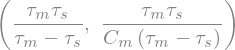

In [14]:
beta = (tau_m*tau_s)/(tau_m-tau_s)
gamma = beta / C_m
beta, gamma

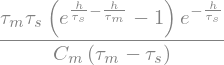

In [15]:
P_32i = gamma * sp.exp(-h/tau_s) * ( sp.exp(h/tau_s - h/tau_m) - 1 )
P_32i

In [16]:
sp.simplify(P_32 - P_32i) == 0

True

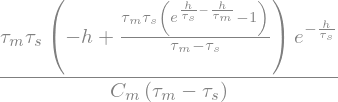

In [17]:
P_31i = gamma * sp.exp(-h/tau_s) * ( beta * (sp.exp(h/tau_s-h/tau_m) - 1) - h )
P_31i

In [18]:
sp.simplify(P_31 - P_31i) == 0

True

### Numerical convergence experiments

- Compute propagator elements as implemented in code
- Test convergence against singular value for $\tau_s\to\tau_m$
- Test for different time steps $h$
- Very small time steps $\mathcal{O}(1 \mu{s})$ can occur in neurons with precise spike times and are thus relevant
- We set $C_m=1$ since it is just a scaling factor 

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nest
nest.set_verbosity('M_ERROR')


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: stinebuu_propagator_class@e1bd3324d
 Built: Oct 17 2022 21:35:01

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [20]:
def calc_p(tau_m, tau_s, h):
    beta = tau_s * tau_m / ( tau_m - tau_s )
    inv_beta = (tau_m - tau_s) / (tau_s * tau_m)
    gamma = beta

    p31 = gamma * np.exp(-h/tau_s) * ( beta * np.expm1(h*inv_beta) - h )
    p31s = 0.5 * h**2 * np.exp(-h/tau_m)
    
    p32 = gamma * np.exp(-h/tau_s) * np.expm1(h*inv_beta)
    p32s = h * np.exp(-h/tau_m)

    return p31, p31s, p32, p32s

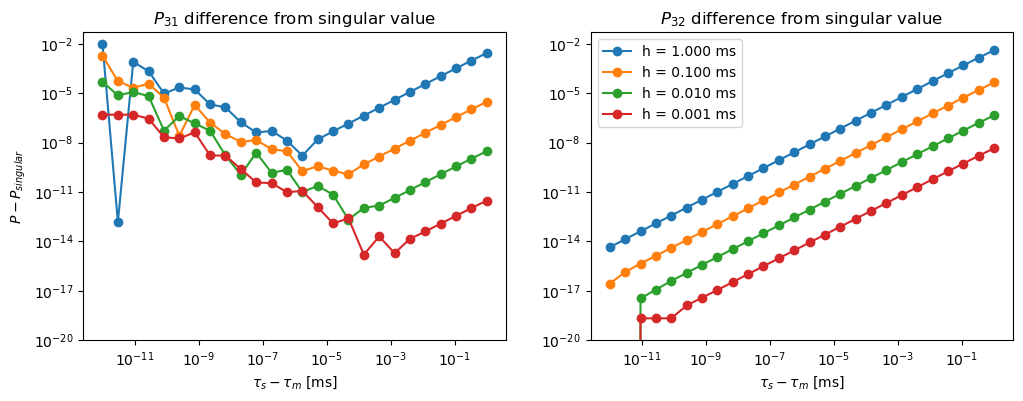

In [21]:
tau_m = 10.
tau_s = tau_m + np.logspace(-12, 0, 26)
h = np.array([[1, 0.1, 0.01, 0.001]]).T
p31, p31s, p32, p32s = calc_p(tau_m, tau_s, h)

fig = plt.figure(figsize=(12, 4));
ax1 = fig.add_subplot(1, 2, 1);
ax1.loglog(np.abs(tau_s-tau_m), np.abs(p31-p31s).T, 'o-');
ax1.set_ylabel('$P - P_{singular}$')
ax1.set_ylim([1e-20, 5e-2])
ax1.set_xlabel(r'$\tau_s - \tau_m$ [ms]');
ax1.set_title('$P_{31}$ difference from singular value');
ax2 = fig.add_subplot(1, 2, 2);
ax2.loglog(np.abs(tau_s-tau_m), np.abs(p32-p32s).T, 'o-', 
           label=[f'h = {hv:.3f} ms' for hv in h[:, 0]]);
ax2.set_ylim([1e-20, 5e-2]);
ax2.set_xlabel(r'$\tau_s - \tau_m$ [ms]');
ax2.set_title('$P_{32}$ difference from singular value');
plt.legend();

- $P_{32}$ shows perfect convergence towards the singular value up to the limits of numerical accuracy
    - This holds for all step sizes $h$
    - This is plausible because $P_{32}$ contains multiplications only: `gamma * np.exp(-h/tau_s) * np.expm1(h*inv_beta)`
    - The only difference is handled internally in `expm1()` and `inv_beta` goes to 0 in the limit
    - Thus **no singularity handling is needed for $P_{32}$**.
- $P_{31}$ converges only up to a point, which depends on the size of the time step $h$
    - Numerical instability occurs for smaller differences in time constants
    - Instability occurs earlier for *smaller* time steps
    - The instability arises from the difference `beta * np.expm1(h*inv_beta) - h`
    - There seems to be no way to reformulate the propagator to avoid this 
    
#### $P_{31}$ instability and membrane time constant

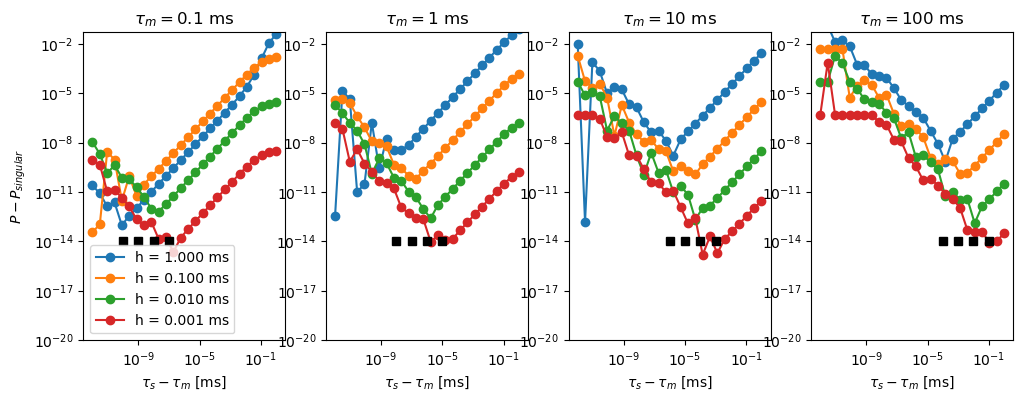

In [22]:
h = np.array([[1, 0.1, 0.01, 0.001]]).T
tau_ms = [0.1, 1, 10, 100]
delta_tau = np.logspace(-12, 0, 26)

fig = plt.figure(figsize=(12, 4));
for ix, tau_m in enumerate(tau_ms):
    tau_s = tau_m + delta_tau
    p31, p31s, _, _ = calc_p(tau_m, tau_s, h)

    ax = fig.add_subplot(1, len(tau_ms), ix+1);
    ax.loglog(np.abs(tau_s-tau_m), np.abs(p31-p31s).T, 'o-',
              label=[f'h = {hv:.3f} ms' for hv in h[:, 0]]);
    for hv in h[:, 0]:
        ax.loglog(1e-8*tau_m**2/hv, 1e-14, 'ks')
    ax.set_ylim([1e-20, 5e-2])
    ax.set_xlabel(r'$\tau_s - \tau_m$ [ms]');
    ax.set_title(f'$\\tau_m = {tau_m}$ ms');
    if ix == 0:
        ax.set_ylabel('$P - P_{singular}$')
        plt.legend();

- The point at which numerical instability occurs clearly depends on the membrane time constant
- As indicated by the markers, the breakdown point is located roughly for $$\tau_s - \tau_m < 10^{-8}\times\frac{\tau_m^2}{h}$$
- We can thus use $$(\tau_s - \tau_m)h < 10^{-8}\times \tau_m^2$$ or 
  $$h < 10^{-8}\times\frac{\tau_m^2}{|\tau_s - \tau_m|}$$ as criterium: use $P_{s, 31}$ if this condition is fulfilled.
- To ensure some margin of safety, we can set the limit at $10^{-7}\times\tau_m^2$.

## Algorithm for propagator computing

1. Precompute values that can be precomputed independent of $h$, including useful inverses.
2. Compute $P_{32}$, which will always be stable; replace by singular limit only if a numerically non-normal or non-positive result occurs. 
3. If $h$ is below stability limit (see inequality above), use singular $P_{s, 31}$, otherwise use $P_{31}$.

## Exploration
We will now show that the stability criterion explained above leads to a reasonable behavior for $\tau_s\rightarrow\tau_m$

### Simulation

- Create one neuron for each value of `delta_tau`
- Drive neurons with a single spike
- Measure resulting membrane potential

In [23]:
tau_m = 10.
h = 0.1
delta_tau = np.hstack(([0.], np.logspace(-10, -1, 10)))

nest.ResetKernel()
nest.resolution = h

neurons = nest.Create('iaf_psc_alpha', n=len(delta_tau),
                      params={'tau_m': tau_m,
                              'tau_syn_ex': tau_m + delta_tau})
spike_gen = nest.Create('spike_generator', params={'spike_times': [1.]})
vm = nest.Create('voltmeter', params={'interval': h})

nest.Connect(spike_gen, neurons, syn_spec={'weight':100.})
nest.Connect(vm, neurons)

nest.Simulate(10 * tau_m)

v = pd.DataFrame.from_records(vm.events).set_index('times')

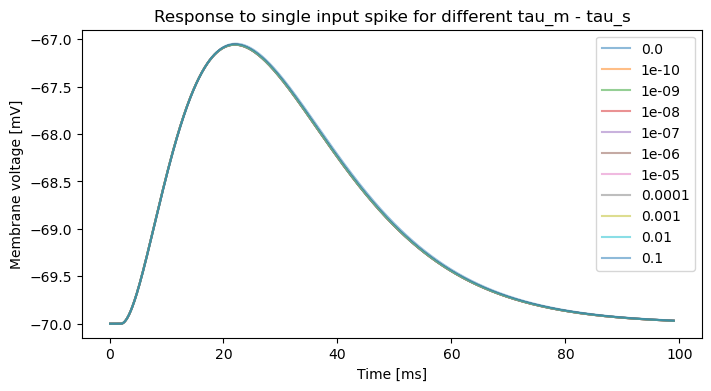

In [24]:
v.groupby('senders').V_m.plot(alpha=0.5, figsize=(8, 4));
plt.legend(delta_tau);
plt.xlabel('Time [ms]');
plt.ylabel('Membrane voltage [mV]');
plt.title('Response to single input spike for different tau_m - tau_s');

### Maximum of membrane potential

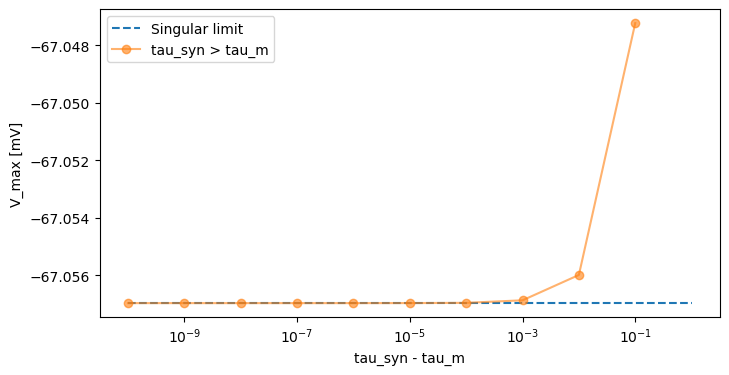

In [25]:
V_max = v.groupby('senders').V_m.max()
plt.figure(figsize=(8, 4));
plt.semilogx([1e-10, 1], [V_max.iloc[0], V_max.iloc[0]], '--');
plt.semilogx(delta_tau[1:], V_max.iloc[1:], 'o-', alpha=0.6);
plt.legend(('Singular limit', 'tau_syn > tau_m'));
plt.xlabel('tau_syn - tau_m');
plt.ylabel('V_max [mV]');

The maximum membrane potential converges smoothly against the singular limit, indicating that no numerical instabilities occur.

-----------------------------
### License

This file is part of NEST. Copyright (C) 2004 The NEST Initiative

NEST is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 2 of the License, or (at your option) any later version.

NEST is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.